In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

In [2]:
# =========================
# From-scratch WEIGHTED Regression Tree (NumPy only)
# + metrics
# + memory-light cost-complexity pruning (α) with CV helpers
# =========================
import numpy as np
from dataclasses import dataclass
from typing import Optional, Tuple, List

# -------- Metrics --------
def wmae(y, yhat, w):
    w = np.asarray(w, float)
    return (np.abs(y - yhat) * w).sum() / w.sum()

def wrmse(y, yhat, w):
    w = np.asarray(w, float)
    return np.sqrt(((y - yhat)**2 * w).sum() / w.sum())

def weighted_r2(y, yhat, w):
    w = np.asarray(w, float)
    ybar = (y * w).sum() / w.sum()
    ss_res = ((y - yhat)**2 * w).sum()
    ss_tot = ((y - ybar)**2 * w).sum()
    return 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0

def poisson_deviance(y_counts, exposure, yhat_rate):
    """
    Exposure-weighted Poisson deviance for counts.
    Safe for zeros: clips lam = rate*exposure and ignores impossible rows (exp<=0 & y>0).
    """
    y   = np.asarray(y_counts,  float)
    exp = np.asarray(exposure,  float)
    lam = np.asarray(yhat_rate, float) * exp

    # guard impossible rows (positive counts with zero/neg exposure)
    bad = (exp <= 0) & (y > 0)
    if np.any(bad):
        y   = y[~bad]
        exp = exp[~bad]
        lam = lam[~bad]

    # clip lambda away from zero
    lam = np.clip(lam, 1e-12, None)

    # safe deviance
    term = np.where(y > 0, y * np.log(y / lam), 0.0) - (y - lam)
    return 2.0 * np.nansum(term)

# -------- Bias–Variance Diagnostic Helper --------
from sklearn.utils import resample
import matplotlib.pyplot as plt

def bias_variance_decomposition(model_class, X, y, w, n_bootstrap=15, **model_params):
    """
    Weighted bias-variance decomposition via bootstrapping.
    - model_class: e.g. DecisionTreeRegressorScratch
    - X, y, w: NumPy arrays
    - n_bootstrap: number of bootstrap fits
    - model_params: hyperparameters for the model
    """
    preds = []
    for i in range(n_bootstrap):
        # Bootstrap sample (with replacement)
        Xb, yb, wb = resample(X, y, w, random_state=42 + i)
        model = model_class(**model_params).fit(Xb, yb, wb)
        preds.append(model.predict(X))
    preds = np.stack(preds, axis=0)  # shape (n_bootstrap, n_samples)

    # Weighted bias², variance, and MSE
    yhat_mean = preds.mean(axis=0)
    bias2 = ((yhat_mean - y)**2 * w).sum() / w.sum()
    var = (preds.var(axis=0, ddof=1) * w).sum() / w.sum()
    mse = (((preds - y)**2).mean(axis=0) * w).sum() / w.sum()

    return {"bias2": bias2, "var": var, "mse": mse}


# -------- Helpers --------
def wmean(y, w):
    sw = w.sum()
    return (y * w).sum() / sw if sw > 0 else 0.0

def leaf_sse_from_stats(sw, swy, swy2):
    # SSE = sum w(y - mean)^2 = sum(w*y^2) - (sum(w*y))^2 / sum(w)
    return float(swy2 - (swy * swy) / sw) if sw > 0 else 0.0

@dataclass
class Node:
    feature: Optional[int] = None
    threshold: Optional[float] = None
    left: Optional["Node"] = None
    right: Optional["Node"] = None
    value: Optional[float] = None   # leaf prediction (weighted mean)

    # sufficient stats for THIS NODE'S samples (fixed after fit)
    sw: float = 0.0                  # sum of weights
    swy: float = 0.0                 # sum of w*y
    swy2: float = 0.0                # sum of w*y^2

    # subtree stats (updated during pruning)
    subtree_sse: float = 0.0
    subtree_leaves: int = 1

    def is_leaf(self) -> bool:
        return self.value is not None

class DecisionTreeRegressorScratch:
    """
    Exposure-weighted regression tree for claim rate.
    - Split criterion: minimize weighted SSE.
    - Leaf value: exposure-weighted mean.
    - Pre-pruning: max_depth, min_leaf_weight (exposure units).
    Uses only NumPy for training/prediction.
    """
    def __init__(self, max_depth: Optional[int] = None, min_leaf_weight: float = 5.0):
        self.max_depth = max_depth
        self.min_leaf_weight = float(min_leaf_weight)
        self.root: Optional[Node] = None

    def fit(self, X: np.ndarray, y: np.ndarray, w: np.ndarray):
        X = np.asarray(X, float)
        y = np.asarray(y, float)
        w = np.asarray(w, float)
        idx = np.arange(X.shape[0], dtype=int)
        self.root = self._build_tree(X, y, w, idx, depth=0)
        _update_subtree_stats(self.root)  # init subtree stats        
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = np.asarray(X, float)
        return np.array([self._traverse(x, self.root) for x in X], float)

    # ----- internal: build tree -----
    def _build_tree(self, X, y, w, idx, depth) -> Node:
        sw = w[idx].sum()
        swy = (y[idx] * w[idx]).sum()
        swy2 = ((y[idx] ** 2) * w[idx]).sum()

        # stopping rules
        if (self.max_depth is not None and depth >= self.max_depth) or \
           (sw < 2 * self.min_leaf_weight) or \
           np.allclose(y[idx], y[idx][0]):
            return Node(value=(swy / sw if sw > 0 else 0.0), sw=sw, swy=swy, swy2=swy2,
                        subtree_sse=leaf_sse_from_stats(sw, swy, swy2), subtree_leaves=1)

        feat, thr, L, R = self._best_split(X, y, w, idx)
        if feat is None:
            return Node(value=(swy / sw if sw > 0 else 0.0), sw=sw, swy=swy, swy2=swy2,
                        subtree_sse=leaf_sse_from_stats(sw, swy, swy2), subtree_leaves=1)

        left  = self._build_tree(X, y, w, L, depth+1)
        right = self._build_tree(X, y, w, R, depth+1)
        return Node(feature=feat, threshold=thr, left=left, right=right,
                    value=None, sw=sw, swy=swy, swy2=swy2)

    # ----- internal: best split -----
    def _best_split(self, X, y, w, idx) -> Tuple[Optional[int], Optional[float], Optional[np.ndarray], Optional[np.ndarray]]:     
        best = (None, None, None, None, np.inf)
        n, d = X.shape
        for j in range(d):
            xj = X[idx, j]
            uniq = np.unique(xj)
            if uniq.size <= 1:
                continue
            # thresholds: midpoints; for one-hot 0/1, just 0.5
            if uniq.size == 2 and uniq.min() == 0.0 and uniq.max() == 1.0:
                candidates = [0.5]
            else:
                u = np.unique(np.sort(xj))
                candidates = (u[:-1] + u[1:]) / 2.0

            for t in candidates:
                Lmask = xj <= t
                if not Lmask.any() or Lmask.all():
                    continue
                L = idx[Lmask]; R = idx[~Lmask]

                swL = w[L].sum(); swR = w[R].sum()
                if swL < self.min_leaf_weight or swR < self.min_leaf_weight:
                    continue

                swyL = (y[L] * w[L]).sum(); swyR = (y[R] * w[R]).sum()
                swy2L = ((y[L]**2) * w[L]).sum(); swy2R = ((y[R]**2) * w[R]).sum()
                sseL = leaf_sse_from_stats(swL, swyL, swy2L)
                sseR = leaf_sse_from_stats(swR, swyR, swy2R)
                sse  = sseL + sseR
                if sse < best[4]:
                    best = (j, t, L, R, sse)

        return best[0], best[1], best[2], best[3]

    # ----- internal: predict one -----
    def _traverse(self, x, node: Node) -> float:
        while node.value is None:
            node = node.left if x[node.feature] <= node.threshold else node.right
        return node.value

# ---- subtree stat maintenance & pruning (streaming, memory-light) ----
def _update_subtree_stats(node: Node) -> Tuple[float, int]:
    if node.value is not None:
        node.subtree_sse = leaf_sse_from_stats(node.sw, node.swy, node.swy2)
        node.subtree_leaves = 1
        return node.subtree_sse, 1
    sL, lL = _update_subtree_stats(node.left)
    sR, lR = _update_subtree_stats(node.right)
    node.subtree_sse = sL + sR
    node.subtree_leaves = lL + lR
    return node.subtree_sse, node.subtree_leaves

def _alpha_of(node: Node) -> float:
    if node.value is not None:
        return np.inf
    sse_leaf = leaf_sse_from_stats(node.sw, node.swy, node.swy2)
    denom = max(node.subtree_leaves - 1, 1e-12)
    return (sse_leaf - node.subtree_sse) / denom

def _collect_internal(node: Node, acc: List[Node]):
    if node is None or node.value is not None:
        return
    acc.append(node)
    _collect_internal(node.left, acc)
    _collect_internal(node.right, acc)

def _prune_once_inplace(root: Node) -> float:
    """Prune all nodes with minimal α (weakest-link). Returns α*."""
    _update_subtree_stats(root)
    internals: List[Node] = []
    _collect_internal(root, internals)
    if not internals:
        return np.inf
    alphas = np.array([_alpha_of(n) for n in internals])
    a_star = float(alphas.min())
    tol = 1e-12

    def prune_mark(n: Node):
        if n.value is not None:
            return
        a = _alpha_of(n)
        if abs(a - a_star) <= tol:
            # turn node into LEAF using fixed stats
            mu = (n.swy / n.sw) if n.sw > 0 else 0.0
            n.feature = n.threshold = None
            n.left = n.right = None
            n.value = float(mu)
            n.subtree_sse = leaf_sse_from_stats(n.sw, n.swy, n.swy2)
            n.subtree_leaves = 1
        else:
            prune_mark(n.left); prune_mark(n.right)

    prune_mark(root)
    _update_subtree_stats(root)
    return a_star

def pruning_path_stream(root: Node):
    """
    Generator yielding (alpha_star, leaves_now) while pruning in place.
    """
    while True:
        a = _prune_once_inplace(root)
        yield a, root.subtree_leaves
        if root.subtree_leaves == 1 or not np.isfinite(a):
            break

def predict_with_root(X: np.ndarray, root: Node) -> np.ndarray:
    X = np.asarray(X, float)
    def _one(x, node):
        while node.value is None:
            node = node.left if x[node.feature] <= node.threshold else node.right
        return node.value
    return np.array([_one(X[i], root) for i in range(X.shape[0])], float)

def kfold_indices(n_samples: int, n_splits: int, seed=42, shuffle=True):
    rng = np.random.default_rng(seed)
    idx = np.arange(n_samples, dtype=int)
    if shuffle: rng.shuffle(idx)
    folds = np.array_split(idx, n_splits)
    for i in range(n_splits):
        val = folds[i]
        tr  = np.concatenate([folds[j] for j in range(n_splits) if j != i])
        yield tr, val


In [5]:
# =============================
# Load + preprocess + tiny pre-pruning CV (WMAE)
# =============================
import pandas as pd
from preprocessing.preprocessing_utils import preprocess_for_tree  # your function

# Load
train = pd.read_csv("../data/claims_train.csv")
test  = pd.read_csv("../data/claims_test.csv")

# Preprocess (no scaling; OHE cats; returns rate & exposure)
X_tr, y_tr_rate, w_tr = preprocess_for_tree(train)
X_te, y_te_rate, w_te = preprocess_for_tree(test)

# Reconstruct counts for Poisson deviance
y_tr_cnt = (y_tr_rate * w_tr).to_numpy(float)
y_te_cnt = (y_te_rate * w_te).to_numpy(float)

# To NumPy (float32 saves memory / faster)
X_np = X_tr.values.astype(np.float32)
y_np = y_tr_rate.values.astype(np.float32)
w_np = w_tr.values.astype(np.float32)

# Simple hold-out split for quick validation in the grid
rng = np.random.default_rng(42)
idx = np.arange(len(y_np))
rng.shuffle(idx)
cut = int(0.8 * len(idx))
tr_idx, va_idx = idx[:cut], idx[cut:]

X_tr_np, y_tr_np, w_tr_np = X_np[tr_idx], y_np[tr_idx], w_np[tr_idx]
X_va_np, y_va_np, w_va_np = X_np[va_idx], y_np[va_idx], w_np[va_idx]
y_va_cnt_np = y_tr_cnt[va_idx]  # counts for Poisson deviance

# ---- Tiny grid over pre-pruning caps (selection by WMAE) ----
depth_grid = [14]
leafw_grid = [18]

best = None
for d in depth_grid:
    for m in leafw_grid:
        tree = DecisionTreeRegressorScratch(max_depth=d, min_leaf_weight=m).fit(X_tr_np, y_tr_np, w_tr_np)
        yhat_va = tree.predict(X_va_np)
        score = wmae(y_va_np, yhat_va, w_va_np)
        if (best is None) or (score < best["wmae"]):
            best = {"max_depth": d, "min_leaf_weight": m, "wmae": score, "yhat_va": yhat_va}
        print(f"Pre-pruning caps: max_depth={d}, min_leaf_weight={m:.1f} => WMAE={score:.6f}")    


print("Chosen pre-pruning caps:", {k: best[k] for k in ["max_depth","min_leaf_weight","wmae"]})

# Validation metrics for the chosen caps
yhat_va = best["yhat_va"]
print("\nValidation metrics (chosen caps):")
print(" WMAE         :", wmae(y_va_np, yhat_va, w_va_np))
print(" WRMSE        :", wrmse(y_va_np, yhat_va, w_va_np))
print(" Weighted R^2 :", weighted_r2(y_va_np, yhat_va, w_va_np))
print(" Poisson Dev. :", poisson_deviance(y_va_cnt_np, w_va_np, yhat_va))


# ===========================================
# Baseline comparisons (VALIDATION split)
# ===========================================
print("\n=== Baseline comparisons (VALIDATION) ===")

# 1) Global-mean baseline (exposure-weighted)
ybar_w_val = float((y_va_np * w_va_np).sum() / w_va_np.sum())
wmae_global_val = wmae(y_va_np, np.full_like(y_va_np, ybar_w_val), w_va_np)
print(f"Global-mean WMAE (val): {wmae_global_val:.6f}")

# 2) Group-mean baseline by Area (if 'Area' is available in the original train df)
#    We align rows by using the validation indices into the original preprocessed X_tr (DataFrame)
try:
    val_row_labels = X_tr.index[va_idx]
    area_val = train.loc[val_row_labels, "Area"]

    df_val_tmp = pd.DataFrame({
        "Area": area_val.values,
        "y":    y_tr_rate.loc[val_row_labels].values,
        "w":    w_tr.loc[val_row_labels].values
    })
    # vectorized weighted means per Area
    sums = df_val_tmp.assign(yw=df_val_tmp["y"]*df_val_tmp["w"]).groupby("Area")[["yw","w"]].sum()
    grp_mean_val = (sums["yw"] / sums["w"]).to_dict()

    yhat_group_val = area_val.map(grp_mean_val).to_numpy(dtype=np.float32)
    wmae_group_val = wmae(y_va_np, yhat_group_val, w_va_np)
    print(f"Group-mean (Area) WMAE (val): {wmae_group_val:.6f}")
except Exception as e:
    print("Group-mean baseline (val) skipped (Area not available / alignment issue).", e)

# 3) Compare your model to baselines on validation
wmae_model_val = wmae(y_va_np, yhat_va, w_va_np)
print(f"Model WMAE (val): {wmae_model_val:.6f}")
print(f"Improvement vs Global (val): {1 - (wmae_model_val / wmae_global_val):.2%}")
try:
    print(f"Improvement vs Group (Area, val): {1 - (wmae_model_val / wmae_group_val):.2%}")
except:
    pass

Pre-pruning caps: max_depth=14, min_leaf_weight=18.0 => WMAE=0.181629
Chosen pre-pruning caps: {'max_depth': 14, 'min_leaf_weight': 18, 'wmae': np.float64(0.18162908107788722)}

Validation metrics (chosen caps):
 WMAE         : 0.18162908107788722
 WRMSE        : 0.7404891122545278
 Weighted R^2 : 0.012237945039458298
 Poisson Dev. : 43623.02355559505

=== Baseline comparisons (VALIDATION) ===
Global-mean WMAE (val): 0.189786
Group-mean (Area) WMAE (val): 0.189543
Model WMAE (val): 0.181629
Improvement vs Global (val): 4.30%
Improvement vs Group (Area, val): 4.18%


C:\Users\stell\AppData\Local\Temp\ipykernel_34840\1782650842.py:46: RuntimeWarning: divide by zero encountered in log
  term = np.where(y > 0, y * np.log(y / lam), 0.0) - (y - lam)
C:\Users\stell\AppData\Local\Temp\ipykernel_34840\1782650842.py:46: RuntimeWarning: invalid value encountered in multiply
  term = np.where(y > 0, y * np.log(y / lam), 0.0) - (y - lam)


In [6]:
# =============================
# FAST post-pruning via compressed α-grid + small CV
# =============================

# ---- knobs you can tweak ----
K_FOLDS = 5                # 3-fold CV for pruning (faster than 5)
MAX_ALPHA_POINTS = 30       # at most this many α’s evaluated
USE_HOLDOUT_INSTEAD_OF_CV = True  # set True for ultra-fast single holdout selection

def _global_alpha_grid(X, y, w, base_params, max_points=30):
    """
    Build a base tree once and stream its pruning alphas,
    then compress to <= max_points via quantiles.
    """
    # stream alphas
    alphas = []
    root = DecisionTreeRegressorScratch(**base_params).fit(X, y, w).root
    for a, _ in pruning_path_stream(root):
        if np.isfinite(a): alphas.append(a)
        if getattr(root, "subtree_leaves", 1) == 1: break
    if not alphas:
        return np.array([0.0], float)
    alphas = np.array(alphas, float)
    if alphas.size <= max_points:
        return np.unique(alphas)
    qs = np.linspace(0, 1, max_points)
    return np.unique(np.quantile(alphas, qs))

def _score_tree_on(Xv, yv, wv, root):
    yhat = predict_with_root(Xv, root)
    return wmae(yv, yhat, wv)

def select_alpha_fast(X, y, w, base_params, kfold=3, max_points=30, seed=7, use_holdout=False):
    """
    Fast(er) α selection:
      - compressed global α grid (<= max_points),
      - either HOLDOUT or small k-fold CV with streaming pruning.
    """
    Agrid = _global_alpha_grid(X, y, w, base_params, max_points=max_points)

    if use_holdout:
        # ---- single holdout ----
        rng = np.random.default_rng(seed)
        idx = np.arange(len(y), dtype=int); rng.shuffle(idx)
        cut = int(0.8 * len(idx))
        tr, va = idx[:cut], idx[cut:]
        base = DecisionTreeRegressorScratch(**base_params).fit(X[tr], y[tr], w[tr])
        best = {"alpha": 0.0, "score": _score_tree_on(X[va], y[va], w[va], base.root)}

        Agrid_sorted = np.sort(Agrid)
        k = 0
        if Agrid_sorted[0] == 0.0:
            k = 1  # we already scored unpruned
        for a, _ in pruning_path_stream(base.root):
            if not np.isfinite(a): break
            while k < len(Agrid_sorted) and a >= Agrid_sorted[k]:
                score = _score_tree_on(X[va], y[va], w[va], base.root)
                if score < best["score"]:
                    best = {"alpha": float(Agrid_sorted[k]), "score": float(score)}
                k += 1
            if getattr(base.root, "subtree_leaves", 1) == 1:
                break
        return {"alpha": best["alpha"], "cv_wmae": best["score"], "alphas": Agrid_sorted}

    # ---- small k-fold CV ----
    scores = np.zeros(len(Agrid), float)
    for tr, va in kfold_indices(len(y), kfold, seed=seed):
        base = DecisionTreeRegressorScratch(**base_params).fit(X[tr], y[tr], w[tr])
        Agrid_sorted = np.sort(Agrid)
        k = 0
        last_s = None
        if Agrid_sorted[0] == 0.0:
            s0 = _score_tree_on(X[va], y[va], w[va], base.root)
            scores[0] += s0
            last_s = s0
            k = 1
        for a, _ in pruning_path_stream(base.root):
            if not np.isfinite(a): break
            # score every Agrid point we just crossed
            while k < len(Agrid_sorted) and a >= Agrid_sorted[k]:
                s = _score_tree_on(X[va], y[va], w[va], base.root)
                scores[k] += s
                last_s = s
                k += 1
            if getattr(base.root, "subtree_leaves", 1) == 1:
                break
        # fill any remaining α points in this fold with the last known score
        if last_s is not None and k < len(Agrid_sorted):
            scores[k:] += last_s

# ===== run the fast selection =====
base_params = {"max_depth": best["max_depth"], "min_leaf_weight": best["min_leaf_weight"]}
alpha_sel = select_alpha_fast(
    X_np, y_np, w_np,
    base_params=base_params,
    kfold=K_FOLDS,
    max_points=MAX_ALPHA_POINTS,
    seed=7,
    use_holdout=USE_HOLDOUT_INSTEAD_OF_CV
)
alpha_star = alpha_sel["alpha"]
print("Chosen α (fast):", alpha_star, "| score:", alpha_sel["cv_wmae"])

# ===== prune a base tree on ALL training up to α* (streaming; in place) =====
final_base = DecisionTreeRegressorScratch(**base_params).fit(X_np, y_np, w_np)
for a, _ in pruning_path_stream(final_base.root):
    if not np.isfinite(a) or a >= alpha_star or getattr(final_base.root, "subtree_leaves", 1) == 1:
        break

# ---- Test evaluation ----
X_te_np = X_te.values.astype(np.float32)
y_te_np = y_te_rate.values.astype(np.float32)
w_te_np = w_te.values.astype(np.float32)
yhat_te = predict_with_root(X_te_np, final_base.root)

print("\nTest metrics (final pruned tree - FAST):")
print(" WMAE         :", wmae(y_te_np, yhat_te, w_te_np))
print(" WRMSE        :", wrmse(y_te_np, yhat_te, w_te_np))
print(" Weighted R^2 :", weighted_r2(y_te_np, yhat_te, w_te_np))
y_te_cnt_np = (y_te_np * w_te_np).astype(np.float32)
print(" Poisson Dev. :", poisson_deviance(y_te_cnt_np, w_te_np, yhat_te))


# ===========================================
# Baseline comparisons (TEST split)
# ===========================================
print("\n=== Baseline comparisons (TEST) ===")

# 1) Global-mean baseline (exposure-weighted)
y_te_np = y_te_rate.values.astype(np.float32)
w_te_np = w_te.values.astype(np.float32)
ybar_w_te = float((y_te_np * w_te_np).sum() / w_te_np.sum())
wmae_global_te = wmae(y_te_np, np.full_like(y_te_np, ybar_w_te), w_te_np)
print(f"Global-mean WMAE (test): {wmae_global_te:.6f}")

# 2) Group-mean baseline by Area (if 'Area' is available in the original test df)
#    We align rows by using the X_te index into the original 'test' DataFrame
try:
    area_te = test.loc[X_te.index, "Area"]
    df_te_tmp = pd.DataFrame({
        "Area": area_te.values,
        "y":    y_te_rate.loc[X_te.index].values,
        "w":    w_te.loc[X_te.index].values
    })
    sums_te = df_te_tmp.assign(yw=df_te_tmp["y"]*df_te_tmp["w"]).groupby("Area")[["yw","w"]].sum()
    grp_mean_te = (sums_te["yw"] / sums_te["w"]).to_dict()

    yhat_group_te = area_te.map(grp_mean_te).to_numpy(dtype=np.float32)
    wmae_group_te = wmae(y_te_np, yhat_group_te, w_te_np)
    print(f"Group-mean (Area) WMAE (test): {wmae_group_te:.6f}")
except Exception as e:
    print("Group-mean baseline (test) skipped (Area not available / alignment issue).", e)

# 3) Compare your model to baselines on test
wmae_model_te = wmae(y_te_np, yhat_te, w_te_np)
print(f"Model WMAE (test): {wmae_model_te:.6f}")
print(f"Improvement vs Global (test): {1 - (wmae_model_te / wmae_global_te):.2%}")
try:
    print(f"Improvement vs Group (Area, test): {1 - (wmae_model_te / wmae_group_te):.2%}")
except:
    pass


Chosen α (fast): 0.10828531442923094 | score: 0.1827193429243397

Test metrics (final pruned tree - FAST):
 WMAE         : 0.18312210439549695
 WRMSE        : 0.7748361550574862
 Weighted R^2 : 0.01268841109464991
 Poisson Dev. : 48387.05777551274

=== Baseline comparisons (TEST) ===
Global-mean WMAE (test): 0.191320
Group-mean (Area) WMAE (test): 0.191140
Model WMAE (test): 0.183122
Improvement vs Global (test): 4.28%
Improvement vs Group (Area, test): 4.19%


C:\Users\stell\AppData\Local\Temp\ipykernel_34840\1782650842.py:46: RuntimeWarning: divide by zero encountered in log
  term = np.where(y > 0, y * np.log(y / lam), 0.0) - (y - lam)
C:\Users\stell\AppData\Local\Temp\ipykernel_34840\1782650842.py:46: RuntimeWarning: invalid value encountered in multiply
  term = np.where(y > 0, y * np.log(y / lam), 0.0) - (y - lam)



=== FINAL (pre-pruned only, α=0) ===
Test WMAE      : 0.1831162719784349
Test WRMSE     : 0.7748639259198842
Test Weighted R^2: 0.012617637459596986
Test Poisson Dev.: 53604.751543446124
Leaves (unpruned, chosen caps): 1824
Global-mean WMAE (test): 0.191320
Group-mean (Area) WMAE (test): 0.191140
Improvement vs Global (test): 4.29%
Improvement vs Group  (test): 4.20%

=== Bias–Variance Decomposition (bootstrapped) ===


C:\Users\stell\AppData\Local\Temp\ipykernel_34840\1782650842.py:46: RuntimeWarning: divide by zero encountered in log
  term = np.where(y > 0, y * np.log(y / lam), 0.0) - (y - lam)
C:\Users\stell\AppData\Local\Temp\ipykernel_34840\1782650842.py:46: RuntimeWarning: invalid value encountered in multiply
  term = np.where(y > 0, y * np.log(y / lam), 0.0) - (y - lam)


Depth=6  | Bias²=0.535918 | Var=0.001168 | MSE=0.536502
Depth=10 | Bias²=0.533250 | Var=0.003179 | MSE=0.534840
Depth=14 | Bias²=0.530600 | Var=0.007012 | MSE=0.534106


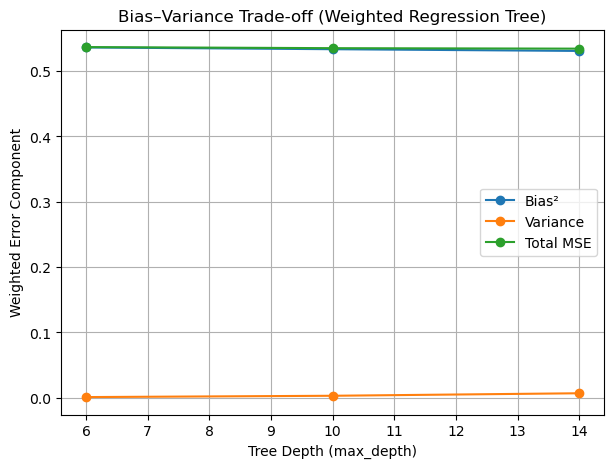

In [8]:
# ===== Final (recommended): pre-pruned only, α = 0 =====
base_params = {"max_depth": 14, "min_leaf_weight": 18.0}

final_unpruned = DecisionTreeRegressorScratch(**base_params).fit(X_np, y_np, w_np)
yhat_test_unpruned = predict_with_root(X_te.values.astype(np.float32), final_unpruned.root)

print("\n=== FINAL (pre-pruned only, α=0) ===")
print("Test WMAE      :", wmae(y_te_rate.values.astype(np.float32), yhat_test_unpruned, w_te.values.astype(np.float32)))
print("Test WRMSE     :", wrmse(y_te_rate.values.astype(np.float32), yhat_test_unpruned, w_te.values.astype(np.float32)))
print("Test Weighted R^2:", weighted_r2(y_te_rate.values.astype(np.float32), yhat_test_unpruned, w_te.values.astype(np.float32)))
y_te_cnt_np = (y_te_rate.values.astype(np.float32) * w_te.values.astype(np.float32))
print("Test Poisson Dev.:", poisson_deviance(y_te_cnt_np, w_te.values.astype(np.float32), yhat_test_unpruned))

# Leaf counts for interpretability
print("Leaves (unpruned, chosen caps):", final_unpruned.root.subtree_leaves)

# Baselines on the same test split
y_te_np = y_te_rate.values.astype(np.float32)
w_te_np = w_te.values.astype(np.float32)
ybar_w_te = float((y_te_np * w_te_np).sum() / w_te_np.sum())
wmae_global_te = wmae(y_te_np, np.full_like(y_te_np, ybar_w_te), w_te_np)
print("Global-mean WMAE (test):", f"{wmae_global_te:.6f}")

try:
    area_te = test.loc[X_te.index, "Area"]
    df_te_tmp = pd.DataFrame({"Area": area_te.values, "y": y_te_rate.loc[X_te.index].values, "w": w_te.loc[X_te.index].values})
    sums_te = df_te_tmp.assign(yw=df_te_tmp["y"]*df_te_tmp["w"]).groupby("Area")[["yw","w"]].sum()
    grp_mean_te = (sums_te["yw"] / sums_te["w"]).to_dict()
    yhat_group_te = area_te.map(grp_mean_te).to_numpy(dtype=np.float32)
    wmae_group_te = wmae(y_te_np, yhat_group_te, w_te_np)
    print("Group-mean (Area) WMAE (test):", f"{wmae_group_te:.6f}")
    print("Improvement vs Global (test):", f"{1 - (wmae(y_te_np, yhat_test_unpruned, w_te_np) / wmae_global_te):.2%}")
    print("Improvement vs Group  (test):", f"{1 - (wmae(y_te_np, yhat_test_unpruned, w_te_np) / wmae_group_te):.2%}")
except Exception as e:
    print("Group-mean baseline (test) skipped:", e)

except Exception as e:
    print("Group-mean baseline (test) skipped:", e)

# ======================================================
# Bias–Variance Trade-off (Bootstrap diagnostic)
# ======================================================

subset = 8000
X_sample = X_np[:subset]
y_sample = y_np[:subset]
w_sample = w_np[:subset]


depth_grid = [6, 10, 14]  # test multiple model complexities
results_bv = []

print("\n=== Bias–Variance Decomposition (bootstrapped) ===")
for d in depth_grid:
    metrics = bias_variance_decomposition(
        DecisionTreeRegressorScratch,
        X_np, y_np, w_np,
        n_bootstrap=2,
        max_depth=d,
        min_leaf_weight=best["min_leaf_weight"]
    )
    results_bv.append({"max_depth": d, **metrics})
    print(f"Depth={d:<2} | Bias²={metrics['bias2']:.6f} | Var={metrics['var']:.6f} | MSE={metrics['mse']:.6f}")

# ---- Plot Bias² vs Variance vs Total MSE ----
depths = [r["max_depth"] for r in results_bv]
bias2  = [r["bias2"] for r in results_bv]
var    = [r["var"] for r in results_bv]
mse    = [r["mse"] for r in results_bv]

plt.figure(figsize=(7,5))
plt.plot(depths, bias2, 'o-', label='Bias²')
plt.plot(depths, var, 'o-', label='Variance')
plt.plot(depths, mse, 'o-', label='Total MSE')
plt.xlabel("Tree Depth (max_depth)")
plt.ylabel("Weighted Error Component")
plt.title("Bias–Variance Trade-off (Weighted Regression Tree)")
plt.legend()
plt.grid(True)
plt.show()
